Your work should meet the following requirements:

1. Data Preprocessing. 
 * Conduct some data preprocessing. (Hint: see if there is any skewed features and consider applying suitable transformation techniques to make them more "normal").
 * Impute the missing values (if any).
2. Predictive Models. 
 * You have to create at least three models: simple linear regression, Lasso and Ridge regression and multilayer perceptron. You may consider creating an ensemble of these models as well (optional). For Lasso and Ridge regression, optimize the alphas using cross validation. You may try other predictive models to get better scores (optional).
3. Evaluation: submit your model to kaggle submission site and report the public score.

Briefly describe your work on each of these steps. Explain (very briefly) what approaches you tried, what worked and what did not work. Mention your team's kaggle name and include a screen shot of your public submission score. Finally, try your best to win this competition!

# Preprocessing

In [123]:
import pandas as pd
from sklearn.ensemble import GradientBoostingClassifier
import numpy as np
import seaborn as sns
%matplotlib inline

In [244]:
train = pd.read_csv("Kaggle Data\\train.csv")
test = pd.read_csv("Kaggle Data\\test.csv")
test_df_copy = test.copy()

In [125]:
train_Ydf = train["SalePrice"]

In [126]:
train_Xdf = train.copy()
del train_Xdf["SalePrice"]

In [127]:
train_Xdf2 = pd.get_dummies(train_Xdf)

In [128]:
train_Xdf2.shape

(1460, 289)

### Finding missing values:

In [129]:

for i in train_Xdf2.columns:
    num_Nan = sum(1*(train_Xdf2.apply(lambda row: str(row[i])=='nan',axis = 1)))
    if num_Nan > 0:
        print i
        print num_Nan

LotFrontage
259
MasVnrArea
8
GarageYrBlt
81


### Interpreting Missing Values:

#### Missing Masonry Vaneer Area Values

In [130]:
train_Xdf2[["MasVnrType_BrkCmn",\
            "MasVnrType_BrkFace",\
            "MasVnrType_None",\
            "MasVnrType_Stone"]][train_Xdf2["MasVnrArea"].map(lambda x: str(x)=='nan')]

,MasVnrType_BrkCmn,MasVnrType_BrkFace,MasVnrType_None,MasVnrType_Stone
234,0.0,0.0,0.0,0.0
529,0.0,0.0,0.0,0.0
650,0.0,0.0,0.0,0.0
936,0.0,0.0,0.0,0.0
973,0.0,0.0,0.0,0.0
977,0.0,0.0,0.0,0.0
1243,0.0,0.0,0.0,0.0
1278,0.0,0.0,0.0,0.0


#### Analysis of missing MasVnrArea data:
It seems that when the "MasVnrArea" column == NaN, there is no indication of what type of masonry vaneer is used. Perhaps, it was not noted because it was not there.

#### Cleaning data steps:
Setting the values equal to zero where missing would solve the problem, as they were probably supposed to be entered as zeros to begin with.

In [131]:
train_Xdf2["MasVnrArea"] = train_Xdf2["MasVnrArea"].map(lambda x: x if str(x)!='nan' else 0)

#### Garage Year Built Missing Values

In [132]:
garage_checkdf = train_Xdf2[['GarageCars','GarageArea',\
            'GarageType_2Types','GarageType_Attchd',\
            'GarageType_Basment','GarageType_BuiltIn',\
            'GarageType_CarPort','GarageType_Detchd',\
            'GarageFinish_Fin','GarageFinish_RFn',\
            'GarageFinish_Unf','GarageQual_Ex',\
            'GarageQual_Fa','GarageQual_Gd',\
            'GarageQual_Po','GarageQual_TA','GarageCond_Ex',\
            'GarageCond_Fa','GarageCond_Gd','GarageCond_Po',\
            'GarageCond_TA']][train_Xdf2["GarageYrBlt"].map(lambda x: str(x)=='nan')]


In [133]:
garage_checkdf.apply(lambda column: sum(column))

GarageCars            0.0
GarageArea            0.0
GarageType_2Types     0.0
GarageType_Attchd     0.0
GarageType_Basment    0.0
GarageType_BuiltIn    0.0
GarageType_CarPort    0.0
GarageType_Detchd     0.0
GarageFinish_Fin      0.0
GarageFinish_RFn      0.0
GarageFinish_Unf      0.0
GarageQual_Ex         0.0
GarageQual_Fa         0.0
GarageQual_Gd         0.0
GarageQual_Po         0.0
GarageQual_TA         0.0
GarageCond_Ex         0.0
GarageCond_Fa         0.0
GarageCond_Gd         0.0
GarageCond_Po         0.0
GarageCond_TA         0.0
dtype: float64

#### Analysis of missing garage year built data:

A missing value seems to indicate the lack of a garage. 

#### Cleaning:

Setting the value equal to the value of the house being built where it is not otherwise indicated would provide a value needed for classification.

In [134]:
train_Xdf2[["GarageYrBlt"]] = train_Xdf2[["GarageYrBlt",\
                            'YearBuilt']].apply(lambda row: row["YearBuilt"]\
                                                if row["GarageYrBlt"]!='nan' \
                                                else row["GarageYrBlt"],axis=1)

### Lot Frontage Missing Values

In [135]:
train_Xdf2[['Street_Grvl','Street_Pave']][train_Xdf2["LotFrontage"].map(lambda x: str(x)=='nan')].head()

,Street_Grvl,Street_Pave
7,0.0,1.0
12,0.0,1.0
14,0.0,1.0
16,0.0,1.0
24,0.0,1.0


The lot frontage indicates the linear feet of street connected to the property. It seems as though there is street connected to the properties in question, though no indication of square footage is given.

A model (below) was built in order to classify these missing terms.

In [136]:
lot_frontage_train = train_Xdf2[train_Xdf2["LotFrontage"].map(lambda x: str(x)!='nan')]
lot_frontage_test = train_Xdf2[train_Xdf2["LotFrontage"].map(lambda x: str(x)=='nan')]

In [137]:
lot_frontage_train_Xmat = lot_frontage_train.drop(["LotFrontage"],axis=1).as_matrix()
lot_frontage_test_Xmat = lot_frontage_test.drop(["LotFrontage"],axis=1).as_matrix()

In [138]:
lot_frontage_train_Ymat = lot_frontage_train[["LotFrontage"]].as_matrix()

In [139]:
from sklearn.neighbors import KNeighborsClassifier as knn

In [140]:
lfc = knn()

In [141]:
lfc.fit(lot_frontage_train_Xmat,lot_frontage_train_Ymat)

C:\Users\Sean\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  if __name__ == '__main__':


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [142]:
y_pred_arr = lfc.predict(lot_frontage_test_Xmat)

In [143]:
y_pred_arr = lfc.predict(lot_frontage_test_Xmat)
y_pred_series = pd.Series(y_pred_arr)

In [144]:
fixing_lot = train_Xdf2[train_Xdf2["LotFrontage"].map(lambda x: str(x)=='nan')]["LotFrontage"].reset_index() 
fixing_lot["LotFrontage"] = y_pred_series

In [145]:
counter = 0
for row_num in range(len(train_Xdf2["LotFrontage"])):
    if str(train_Xdf2["LotFrontage"][row_num]) == 'nan':
        train_Xdf2["LotFrontage"][row_num] = y_pred_arr[counter]
        counter = counter + 1

C:\Users\Sean\AppData\Local\Continuum\Anaconda2\lib\site-packages\ipykernel\__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


#### A final check to ensure no missing values are present:

In [146]:
NaN_arr = []
for i in train_Xdf2.columns:
    num_Nan = sum(1*(train_Xdf2.apply(lambda row: str(row[i])=='nan',axis = 1)))
    if num_Nan > 0:
        print i
        print num_Nan
        NaN_arr.append(i)
if len(NaN_arr)==0:
    print "All rows of all columns have values."

All rows of all columns have values.


In [147]:
len(train_Xdf2.columns)

289

In [148]:
st=""
for i in train.columns:
    st = st+"'"+i+"'"+","
print st

'Id','MSSubClass','MSZoning','LotFrontage','LotArea','Street','Alley','LotShape','LandContour','Utilities','LotConfig','LandSlope','Neighborhood','Condition1','Condition2','BldgType','HouseStyle','OverallQual','OverallCond','YearBuilt','YearRemodAdd','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','MasVnrArea','ExterQual','ExterCond','Foundation','BsmtQual','BsmtCond','BsmtExposure','BsmtFinType1','BsmtFinSF1','BsmtFinType2','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','Heating','HeatingQC','CentralAir','Electrical','1stFlrSF','2ndFlrSF','LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr','KitchenAbvGr','KitchenQual','TotRmsAbvGrd','Functional','Fireplaces','FireplaceQu','GarageType','GarageYrBlt','GarageFinish','GarageCars','GarageArea','GarageQual','GarageCond','PavedDrive','WoodDeckSF','OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','PoolQC','Fence','MiscFeature','MiscVal','MoSold','YrSold','SaleType','SaleCondit

### Data Normalization

Below is a a string containing all the column names that, by their discriptions, seem non-categorical.

In [149]:
m = '''LotFrontage: 
LotArea: 
YearBuilt: 
YearRemodAdd: 
MasVnrArea: 
BsmtFinSF1: 
BsmtFinSF2: 
BsmtUnfSF: 
TotalBsmtSF: 
1stFlrSF:
2ndFlrSF:
LowQualFinSF: 
GrLivArea: 
BsmtFullBath: 
BsmtHalfBath: 
FullBath: Full bathrooms above grade
HalfBath: Half baths above grade
BedroomAbvGr: Bedrooms above grade (does NOT include basement bedrooms)
KitchenAbvGr: Kitchens above grade
TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
Fireplaces: Number of fireplaces
GarageYrBlt: Year garage was built
GarageCars: Size of garage in car capacity
GarageArea: Size of garage in square feet
WoodDeckSF: Wood deck area in square feet
OpenPorchSF: Open porch area in square feet
EnclosedPorch: Enclosed porch area in square feet
3SsnPorch: Three season porch area in square feet
ScreenPorch: Screen porch area in square feet
PoolArea: Pool area in square feet
MiscVal: $Value of miscellaneous feature
MoSold: Month Sold (MM)
YrSold: Year Sold (YYYY)'''


In [150]:
non_cat_col = []
for line in m.split('\n'):
    column = ""
    for char in line:
        if char == ":":
            break
        column = column + char

    non_cat_col.append(column)

In [151]:
train.columns

Index([u'Id', u'MSSubClass', u'MSZoning', u'LotFrontage', u'LotArea',
       u'Street', u'Alley', u'LotShape', u'LandContour', u'Utilities',
       u'LotConfig', u'LandSlope', u'Neighborhood', u'Condition1',
       u'Condition2', u'BldgType', u'HouseStyle', u'OverallQual',
       u'OverallCond', u'YearBuilt', u'YearRemodAdd', u'RoofStyle',
       u'RoofMatl', u'Exterior1st', u'Exterior2nd', u'MasVnrType',
       u'MasVnrArea', u'ExterQual', u'ExterCond', u'Foundation', u'BsmtQual',
       u'BsmtCond', u'BsmtExposure', u'BsmtFinType1', u'BsmtFinSF1',
       u'BsmtFinType2', u'BsmtFinSF2', u'BsmtUnfSF', u'TotalBsmtSF',
       u'Heating', u'HeatingQC', u'CentralAir', u'Electrical', u'1stFlrSF',
       u'2ndFlrSF', u'LowQualFinSF', u'GrLivArea', u'BsmtFullBath',
       u'BsmtHalfBath', u'FullBath', u'HalfBath', u'BedroomAbvGr',
       u'KitchenAbvGr', u'KitchenQual', u'TotRmsAbvGrd', u'Functional',
       u'Fireplaces', u'FireplaceQu', u'GarageType', u'GarageYrBlt',
       u'GarageFinish',

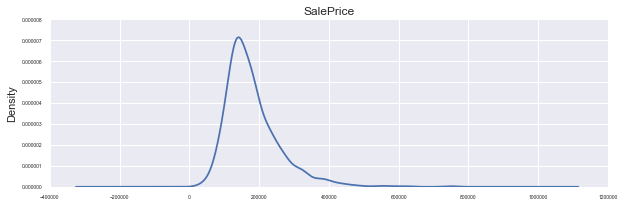

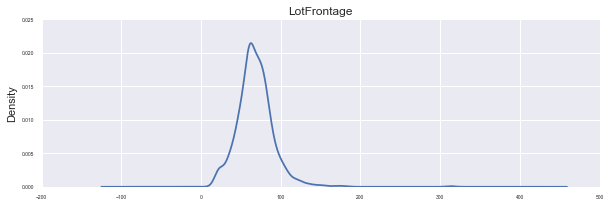

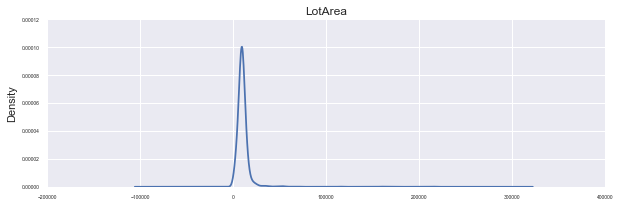

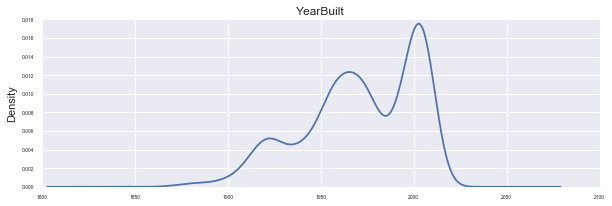

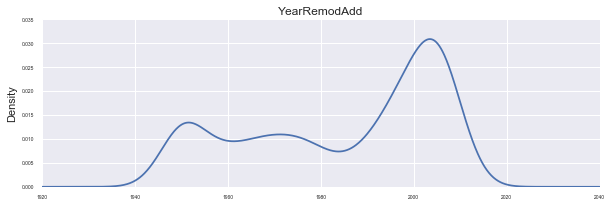

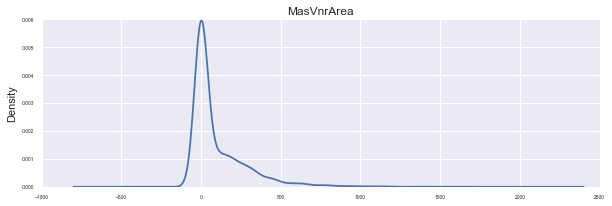

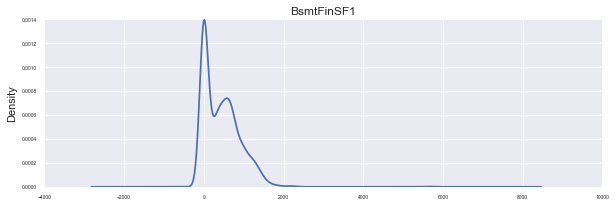

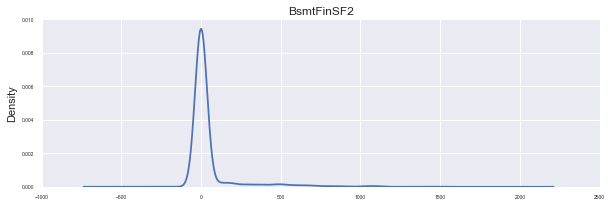

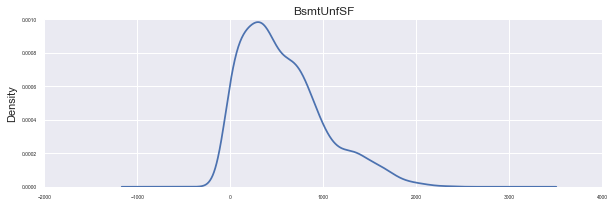

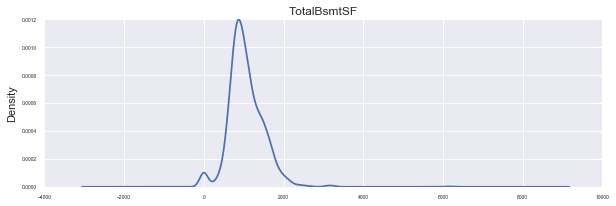

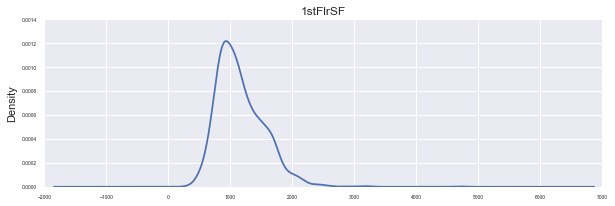

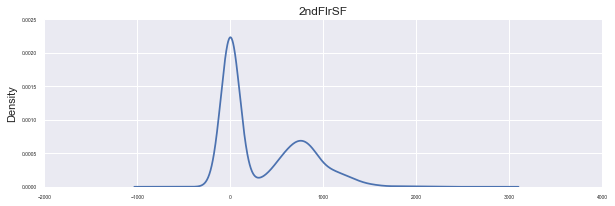

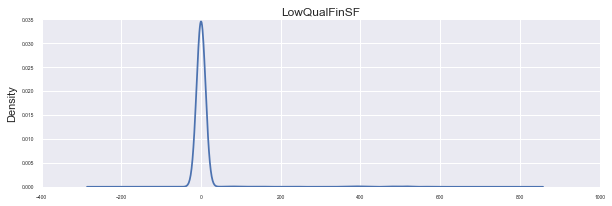

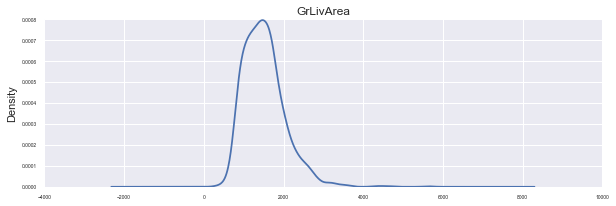

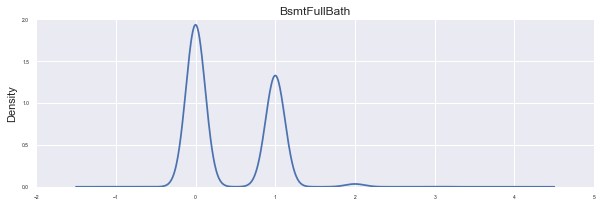

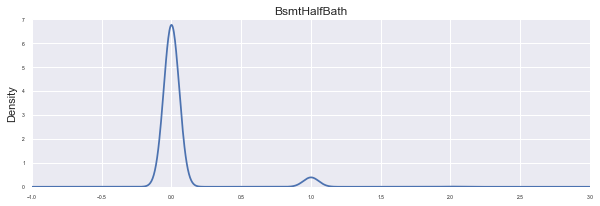

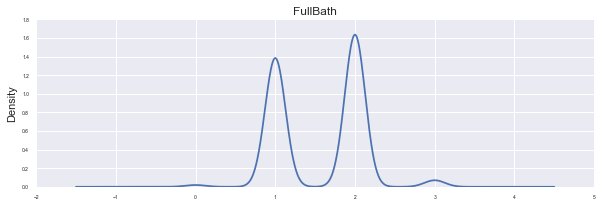

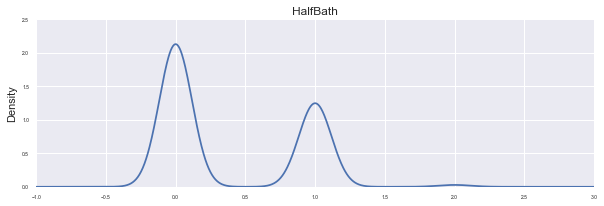

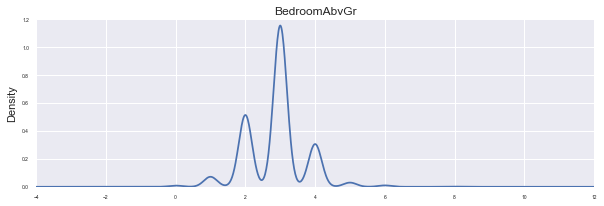

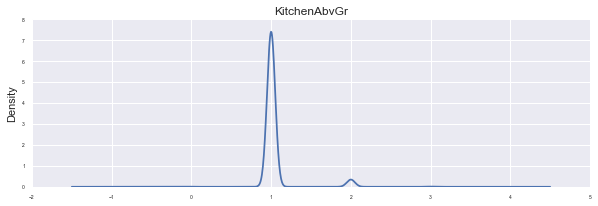

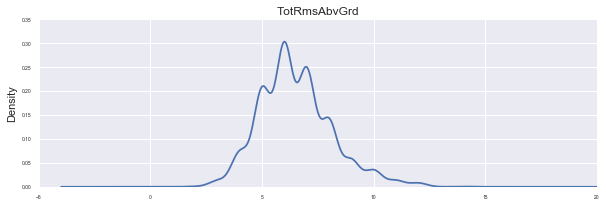

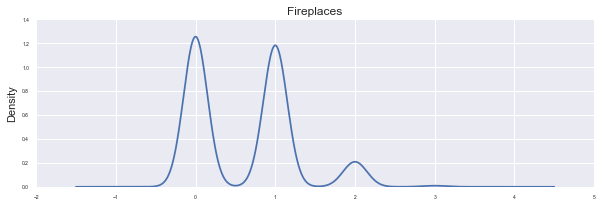

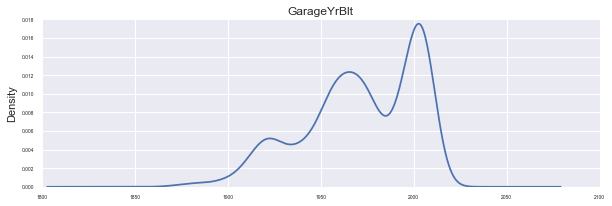

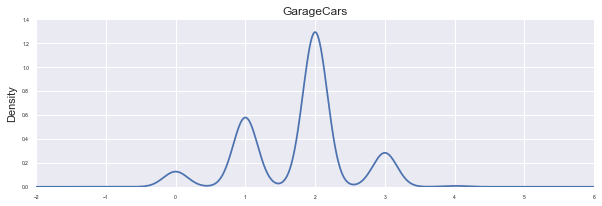

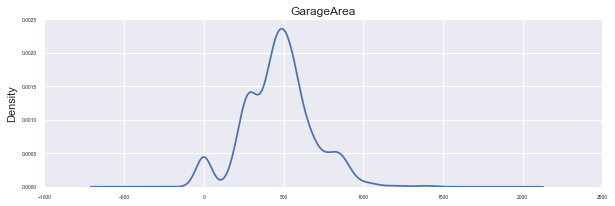

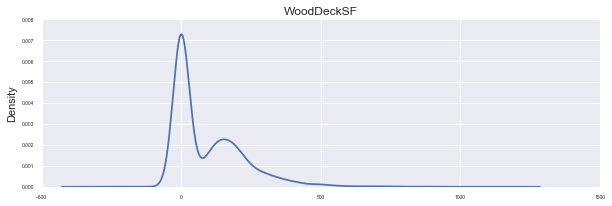

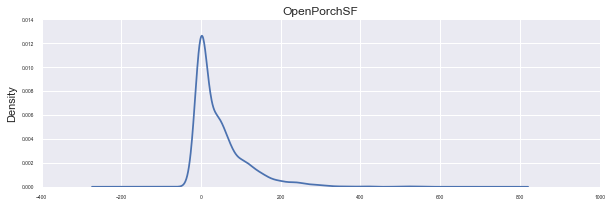

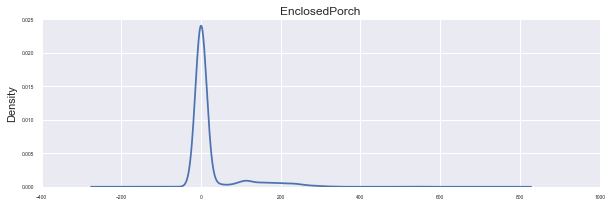

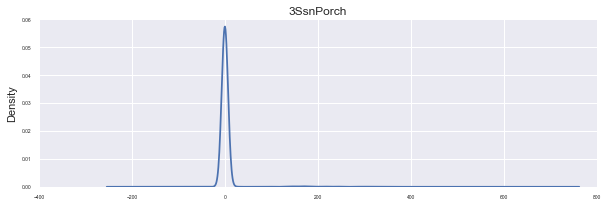

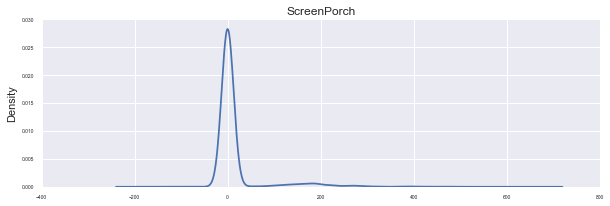

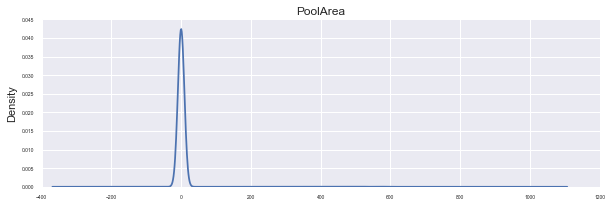

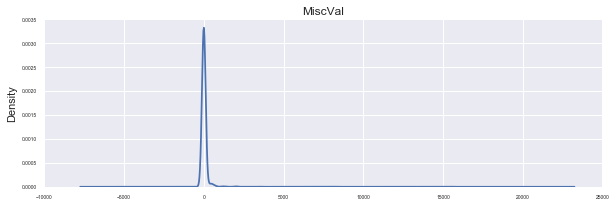

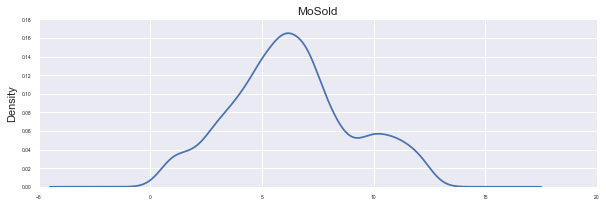

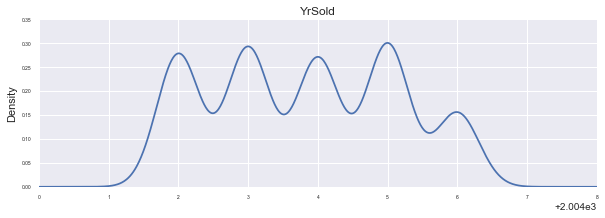

In [153]:
import matplotlib.pyplot as plt
train['SalePrice'].plot(kind='density',figsize=(10,3),fontsize=5, title = 'SalePrice')
plt.show()
for col in non_cat_col:
    train_Xdf2[col].plot(kind='density',figsize=(10,3),fontsize=5, title = col)
    #axs[i].set_title('{}'.format(col))
    #i = i+1
    plt.show()

Left Skewed Distribution Columns:

* GarageYrBlt
* YearBuilt
* YearRemodAdd
  
Right Skewed Distribution Columns:

* MasVnrArea
* BsmtFinSF1
* BsmtUnfSF
* 1stFlrSF
* 2ndFlrSF
* WoodDeckSF
* OpenPorchSF
* SalePrice


In [154]:
skewed_str = '''* GarageYrBlt
* YearBuilt
* YearRemodAdd
* MasVnrArea
* BsmtFinSF1
* BsmtUnfSF
* 1stFlrSF
* 2ndFlrSF
* WoodDeckSF
* OpenPorchSF'''

In [155]:
skewed_col = []
for i in skewed_str.split('\n'):
    skewed_col.append(i[2:])

In [156]:
for col in skewed_col:
    train_Xdf2[col] = train_Xdf2[col].apply(lambda x: np.log(x) if x!= 0 else 0)

In [157]:
train_Ydf = train_Ydf.apply(lambda x: np.log(x) if x!= 0 else 0)

In [158]:
ind = []
for value in train_Xdf2.columns:
    ind.append(value)
for col in skewed_col:
    for i in range(len(train_Xdf2.columns)):
        if train_Xdf2.columns[i]== col:
            st = "Log"
            st = st + col
            ind[i] = st

In [159]:
train_Xdf2.columns = ind

In [160]:
train_Xdf2 = train_Xdf2.drop(["Id"],axis=1)

# 2.

2: Predictive Models. 
 * You have to create at least three models: simple linear regression, Lasso and Ridge regression and multilayer perceptron. You may consider creating an ensemble of these models as well (optional). For Lasso and Ridge regression, optimize the alphas using cross validation. You may try other predictive models to get better scores (optional).

## Linear Regression:

In [167]:
from sklearn.linear_model import LinearRegression as LR
from sklearn.cross_validation import train_test_split

In [168]:
train_Xmat = train_Xdf2.as_matrix()
train_Ymat = train_Ydf.as_matrix()

In [169]:
X_train, X_test, y_train, y_test = train_test_split(train_Xmat, train_Ymat, test_size = 0.3)

In [170]:
lin_reg = LR()

In [171]:
lin_reg.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [172]:
y_test_pred = lin_reg.predict(X_test)

In [201]:
print "R^2 of model is: ", lin_reg.score(X_test,y_test)
print "Out of sample RMSE: ",round(np.sqrt(sum(((np.exp(y_test) - np.exp(y_test_pred))**2)/float(len(y_test)))),1)

R^2 of model is:  0.459886818128
Out of sample RMSE:  643802.3


Note that the model predicts the log price (as the price distribution is skewed), so to calculate the MSE, the exponential of both the test and the prediction is taken

## Lasso:

In [174]:
from sklearn import linear_model
from sklearn.linear_model import LassoCV as las

Populating the interactive namespace from numpy and matplotlib


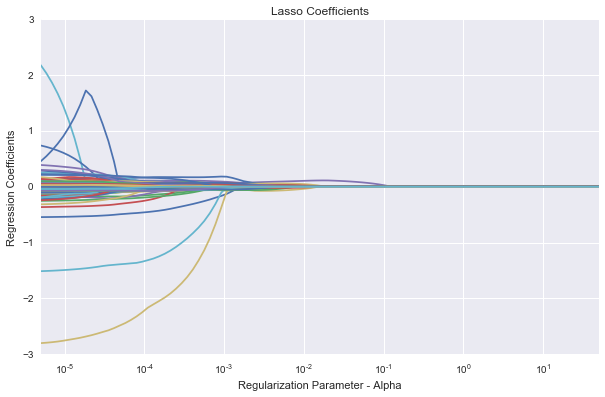

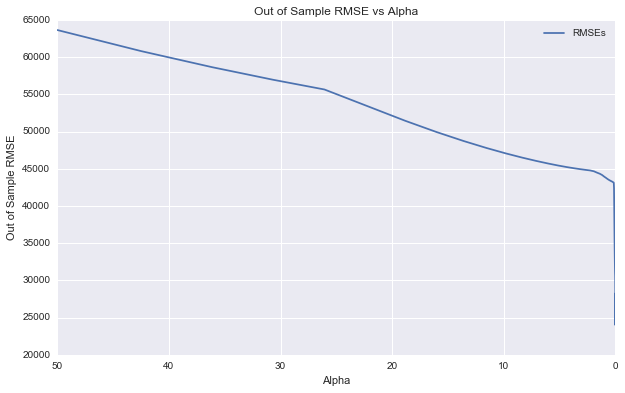

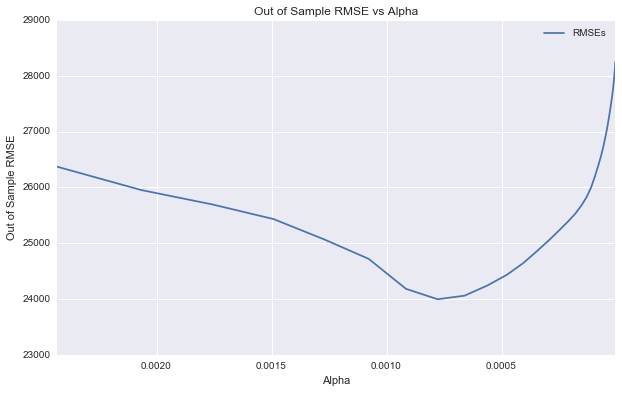

In [226]:
%pylab inline
alphas = 10**np.linspace(2,-5,100)*0.5
df_coefs = pd.DataFrame(np.nan, index = alphas, columns = train_Xdf2.columns.values)

# Lasso Regression

## Initialize lasso model 
lasso = linear_model.Lasso()
## Initialize dataframe to store lasso coefficients
lasso_coefs = df_coefs
## alphas and MSEs:
RMSEs = []
## Fill dataframe with regression coefficients for each value of alpha
for alpha in alphas:
    lasso.alpha = alpha
    lasso.fit(X_train, y_train)
    lasso_coefs.loc[alpha] = lasso.coef_
    lasso_y_test_pred = lasso.predict(X_test)
    RMSEs.append(round(np.sqrt(sum(((np.exp(y_test) - np.exp(lasso_y_test_pred))**2)/float(len(y_test)))),1))

## Plot alpha vs. the value of each coefficients
plt.figure(figsize(10,6))
lasso_coefs.plot(logx=True)
#legend(loc=2, ncol=4)
plt.legend().set_visible(False)
xlim([alphas[-1], alphas[0]])
title('Lasso Coefficients')
xlabel('Regularization Parameter - Alpha')
ylabel('Regression Coefficients')
## Indicate best regularization parameter
#plt.axvline(lasso_alpha, linestyle='--', color='.5')
plt.show()

rmse_alpha_df = pd.DataFrame([alphas,RMSEs])
rmse_alpha_df = rmse_alpha_df.T
rmse_alpha_df.columns = ["Alphas","RMSEs"]
rmse_alpha_df.plot(x="Alphas",y="RMSEs", title = "Out of Sample RMSE vs Alpha")
xlabel('Alpha')
ylabel('Out of Sample RMSE')
plt.show()

rmse_alpha_df[rmse_alpha_df["Alphas"]<0.0025].plot(x="Alphas",y="RMSEs", title = "Out of Sample RMSE vs Alpha")
xlabel('Alpha')
ylabel('Out of Sample RMSE')
plt.show()

Choosing alpha of slightly under 10^-3 would result in the lowest out of sample RMSE. As expected, this is also the point at which the regularization plot stops its steep descent to 0 as alpha increases.

In [ ]:
rmse_alpha_df = rmse_alpha_df.set_index(["Alphas"])

In [239]:
print "At an alpha of ",round(rmse_alpha_df["RMSEs"].idxmin(),2),\
                              ", the lasso regression achieves its lowest out of sample RMSE of ",rmse_alpha_df["RMSEs"].min()
print "As expected, this is also around the point at which the regularization plot stops its steep descent to 0 as alpha increases."

At an alpha of  11.55 , the lasso regression achieves its lowest out of sample RMSE of  24881.1
As expected, this is also around the point at which the regularization plot stops its steep descent to 0 as alpha increases.


# Ridge

Populating the interactive namespace from numpy and matplotlib


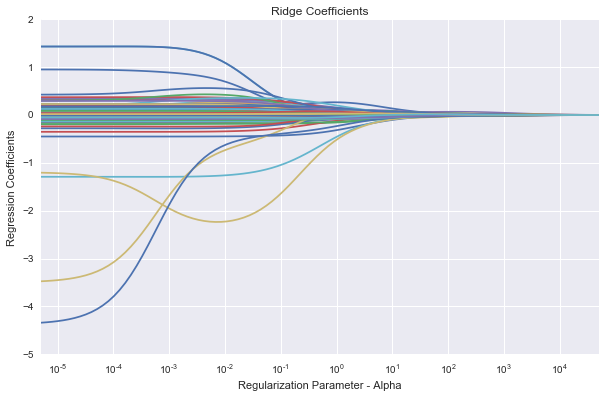

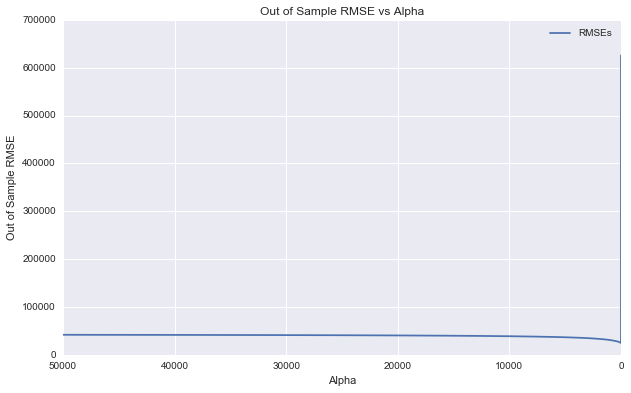

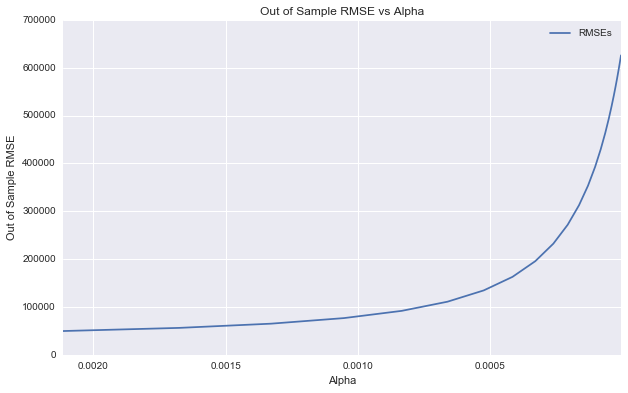

In [232]:
%pylab inline
alphas = 10**np.linspace(5,-5,100)*0.5
df_coefs = pd.DataFrame(np.nan, index = alphas, columns = train_Xdf2.columns.values)

# Lasso Regression

## Initialize lasso model 
ridge = linear_model.Ridge()
## Initialize dataframe to store lasso coefficients
ridge_coefs = df_coefs
## alphas and MSEs:
RMSEs = []
## Fill dataframe with regression coefficients for each value of alpha
for alpha in alphas:
    ridge.alpha = alpha
    ridge.fit(X_train, y_train)
    ridge_coefs.loc[alpha] = ridge.coef_
    ridge_y_test_pred = ridge.predict(X_test)
    RMSEs.append(round(np.sqrt(sum(((np.exp(y_test) - np.exp(ridge_y_test_pred))**2)/float(len(y_test)))),1))

## Plot alpha vs. the value of each coefficients
plt.figure(figsize(10,6))
ridge_coefs.plot(logx=True)
#legend(loc=2, ncol=4)
plt.legend().set_visible(False)
xlim([alphas[-1], alphas[0]])
title('Ridge Coefficients')
xlabel('Regularization Parameter - Alpha')
ylabel('Regression Coefficients')
## Indicate best regularization parameter
#plt.axvline(lasso_alpha, linestyle='--', color='.5')
plt.show()

rmse_alpha_df = pd.DataFrame([alphas,RMSEs])
rmse_alpha_df = rmse_alpha_df.T
rmse_alpha_df.columns = ["Alphas","RMSEs"]
rmse_alpha_df.plot(x="Alphas",y="RMSEs", title = "Out of Sample RMSE vs Alpha")
xlabel('Alpha')
ylabel('Out of Sample RMSE')
plt.show()

rmse_alpha_df[rmse_alpha_df["Alphas"]<0.0025].plot(x="Alphas",y="RMSEs", title = "Out of Sample RMSE vs Alpha")
xlabel('Alpha')
ylabel('Out of Sample RMSE')
plt.show()

It seems a regularization parameter of 10 

In [233]:
rmse_alpha_df = rmse_alpha_df.set_index(["Alphas"])

In [238]:
print "At an alpha of ",round(rmse_alpha_df["RMSEs"].idxmin(),2),", the lasso regression achieves its lowest out of sample RMSE of ",rmse_alpha_df["RMSEs"].min()
print "As expected, this alpha appears around the part of the ridge regularization curve at which coefficients are not"
print "varying greatly, but are also not regularized to the extent that they are essentially zero."

At an alpha of  11.55 , the lasso regression achieves its lowest out of sample RMSE of  24881.1
As expected, this alpha appears around the part of the ridge regularization curve at which coefficients are not
varying greatly, but are also not regularized to the extent that they are essentially zero.


In [245]:
test_df_copy

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
5,1466,60,RL,75.0,10000,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2010,WD,Normal
6,1467,20,RL,NaN,7980,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,GdPrv,Shed,500,3,2010,WD,Normal
7,1468,60,RL,63.0,8402,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,5,2010,WD,Normal
8,1469,20,RL,85.0,10176,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,2,2010,WD,Normal
9,1470,20,RL,70.0,8400,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,4,2010,WD,Normal


In [176]:
lasso_y_test_pred = lasso.predict(X_test)

In [177]:
print "R^2 of model is: ", lin_reg.score(X_test,y_test)
print "Out of sample MSE: ",sum(((np.exp(y_test) - np.exp(lasso_y_test_pred))**2)/float(len(y_test)))

R^2 of model is:  0.459886818128
Out of sample MSE:  798120053.584


In [178]:
lasso.fit(X_train, y_train)

Lasso(alpha=5.0000000000000004e-06, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [180]:
np.linspace(10,-2,100)*0.5

array([ 5.        ,  4.93939394,  4.87878788,  4.81818182,  4.75757576,
        4.6969697 ,  4.63636364,  4.57575758,  4.51515152,  4.45454545,
        4.39393939,  4.33333333,  4.27272727,  4.21212121,  4.15151515,
        4.09090909,  4.03030303,  3.96969697,  3.90909091,  3.84848485,
        3.78787879,  3.72727273,  3.66666667,  3.60606061,  3.54545455,
        3.48484848,  3.42424242,  3.36363636,  3.3030303 ,  3.24242424,
        3.18181818,  3.12121212,  3.06060606,  3.        ,  2.93939394,
        2.87878788,  2.81818182,  2.75757576,  2.6969697 ,  2.63636364,
        2.57575758,  2.51515152,  2.45454545,  2.39393939,  2.33333333,
        2.27272727,  2.21212121,  2.15151515,  2.09090909,  2.03030303,
        1.96969697,  1.90909091,  1.84848485,  1.78787879,  1.72727273,
        1.66666667,  1.60606061,  1.54545455,  1.48484848,  1.42424242,
        1.36363636,  1.3030303 ,  1.24242424,  1.18181818,  1.12121212,
        1.06060606,  1.        ,  0.93939394,  0.87878788,  0.81

Note: The legend was removed due to its size.

In [181]:
for i, j in enumerate(ys):
    print i, j

NameError: name 'ys' is not defined

In [ ]:
for i in range(5):
    raw_input("H")

In [ ]:
feature_importance = grad.feature_importances_
# make importances relative to max importance
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
import matplotlib.pyplot as plt
plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, train_Xdf2.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()

In [ ]:
sorted_idx

In [ ]:
train.shape